# **7. Validacion Avanzada, Tuning e Interpretabilidad a los modelos estudiados**

## 7. SVM

In [23]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skopt import BayesSearchCV

from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier



from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, auc, classification_report, roc_auc_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN
import joblib
import os 



Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [24]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [25]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [29]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calcular AUC si hay probabilidades
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Mostrar métricas
    print(f"Modelo: {nombre_modelo}")
    print("Accuracy:", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:", round(recall, 3))
    print("F1-score:", round(f1, 3))
    if auc is not None:
        print("AUC:", round(auc, 3))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend(loc="lower right")
        plt.show()

    # Retornar resultados en formato de diccionario
    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }


In [30]:
# svm_rbf_pipe = ImbPipeline(steps=[
#     ("preprocessor", preprocessor),  # usa tu preprocesador ya definido
#     ("smote", SMOTE(random_state=42)),
#     ("classifier", SVC(
#         kernel="rbf",
#         probability=True,
#         random_state=42
#     ))
# ])


In [31]:
sgd_pipe = ImbPipeline(steps=[
    ("preprocessor", preprocessor),  # tu transformador definido antes
    ("smote", SMOTE(random_state=42)),
    ("classifier", SGDClassifier(
        loss="hinge",          # equivalente a SVM lineal
        penalty="l2",          # regularización L2
        max_iter=1000,
        tol=1e-3,
        random_state=42,
        n_jobs=-1
    ))
])

In [38]:
param_distributions = {
    "classifier__loss": ["hinge", "log_loss", "modified_huber"],
    "classifier__alpha": [1e-4, 1e-3, 1e-2, 1e-1],
    "classifier__penalty": ["l2", "l1", "elasticnet"],
    "classifier__max_iter": [1000, 2000, 3000],
    "classifier__tol": [1e-3, 1e-4, 1e-5]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [48]:
bayes_search = BayesSearchCV(
    estimator=sgd_pipe,
    search_spaces=param_distributions,
    n_iter=30,
    cv=cv,
    scoring='roc_auc',
    n_jobs=12,
    random_state=42,
    verbose=2
)


In [49]:
bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          StandardScaler(),
                                                                          Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                                         (...
                                         SGDClassifier(n_jobs=-1,
                                                       random_state=42))]),
              n_iter=30, n_jobs=12, random_state=42, scoring='roc_auc',
              search_spaces={'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
                             'classifier__loss': ['hinge', 'log_loss',
                                                  'modified_huber'],
                             'classifier__max_iter': [1000, 2000, 3000],
                             'classifier__penalty': ['l2', 'l1', 'elasticnet'],
                             'classifier__tol': [0.001, 0.0001, 1e-05]},
              verbose=2)

In [50]:
best_svm = bayes_search.best_estimator_

print("Mejores hiperparámetros:", bayes_search.best_params_)
print("Mejor AUC (CV):", bayes_search.best_score_)

y_pred = best_svm.predict(X_test)
y_pred_proba = best_svm.predict_proba(X_test)[:,1]

print("\nMétricas en test:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))

Mejores hiperparámetros: OrderedDict([('classifier__alpha', 0.001), ('classifier__loss', 'log_loss'), ('classifier__max_iter', 3000), ('classifier__penalty', 'l2'), ('classifier__tol', 1e-05)])
Mejor AUC (CV): 0.6786214896038898

Métricas en test:
Accuracy: 0.6233172840719269
Precision: 0.5900588482555695
Recall: 0.5985502611661869
F1: 0.5942742234217071
AUC: 0.6783535398731853


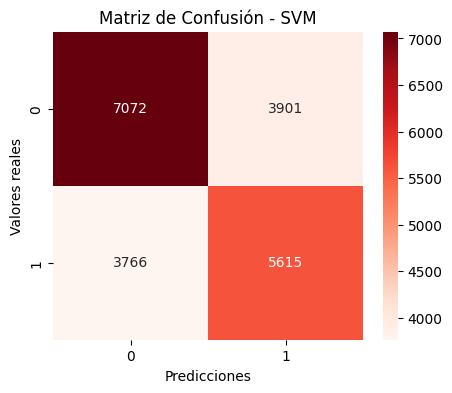

In [51]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión - SVM")
plt.show()



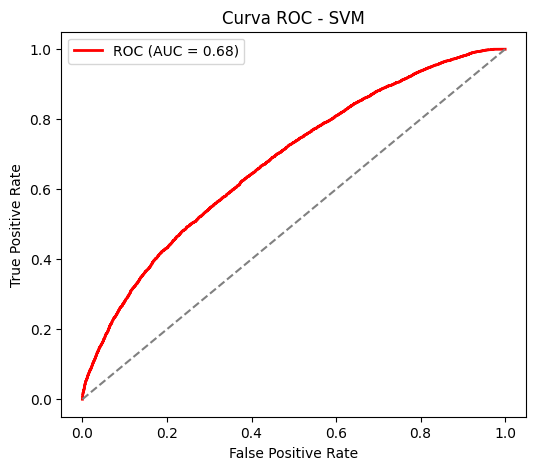

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - SVM")
plt.legend()
plt.show()

In [53]:
joblib.dump(best_svm, "best_svm_pipeline.pkl")
print("Modelo SVM guardado en best_svm_pipeline.pkl")

Modelo SVM guardado en best_svm_pipeline.pkl


In [ ]:
os.system('start "" "C:\\Users\\taran\\OneDrive\\Documents\\Cyberpunk 2077 SFX Johnny silverhand glitch 04 (Sound Effect).mp3"')  # en Windows
